# Experiment 1 - Simple CNN v1

## Model Creation


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
import sklearn.model_selection

model = models.Sequential()
model.add(layers.Conv2D(64, (7, 7), activation='relu',
                        input_shape=(150, 150, 1)))
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# preprocess
images = images.reshape((2676, 150, 150, 1))

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    rescale=1./65535.,
    validation_split=0.2 
    )

train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=1234,
                               subset="training")

valid_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               subset="validation",
                               seed=1234)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          epochs=250)

model.load_weights(checkpoint_filepath)

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/scratch_model_simple_cnn_v1"))
with open(out_path+'/histories/scratch_model_simple_cnn_v1_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/scratch_model_1/assets


## Model evaluation

In [4]:
# load model and model's history
with open(out_path + '/histories/scratch_model_simple_cnn_v1_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_simple_cnn_v1"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


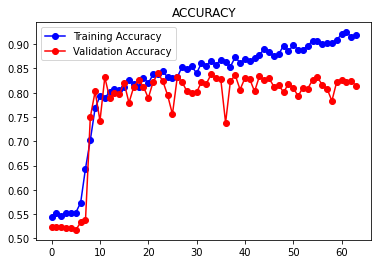

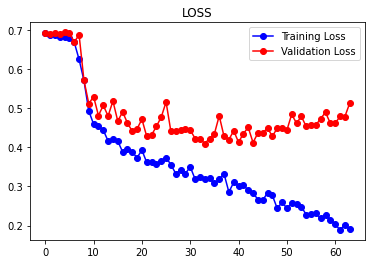

In [5]:
print(history.keys())
# see how the accuracy and the loss change during training
import matplotlib.pyplot as plt
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)


[[149  30]
 [ 39 118]]
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       179
           1       0.80      0.75      0.77       157

    accuracy                           0.79       336
   macro avg       0.79      0.79      0.79       336
weighted avg       0.79      0.79      0.79       336



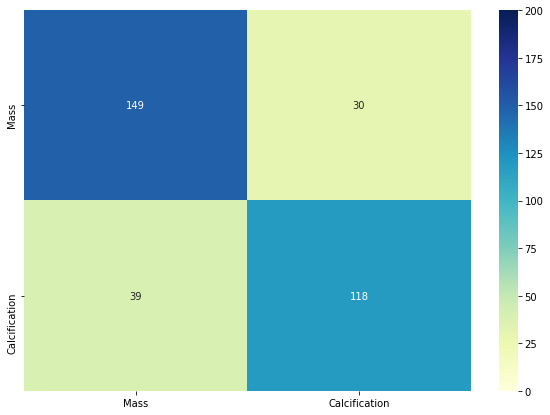

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

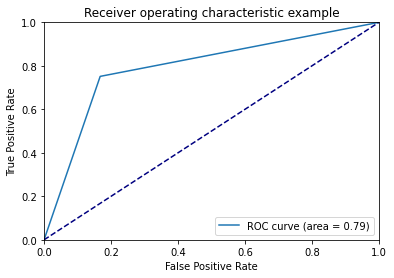

In [ ]:
fpr,tpr,th = metrics.roc_curve(test_images_labels,predictions)

roc_auc = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Experiment 1 - Simple CNN v2

## Model Creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.utils import class_weight
from keras import regularizers
import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
#MODEL 

model = models.Sequential()
model.add(layers.Conv2D(64, (7, 7), activation='relu',
                        input_shape=(150, 150, 1)) )
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((4, 4)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu',kernel_regularizer = regularizers.l1(1e-4)))
model.add(layers.Dense(10, activation='relu',kernel_regularizer = regularizers.l1(1e-4)))
model.add(layers.Dense(1, activation='sigmoid'))

# preprocess
images = images.reshape((2676, 150, 150, 1))

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    rescale=1./65535.,
    validation_split=0.2 ,
    horizontal_flip=True,
    rotation_range = 40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    shear_range=0.2 
    )

valid_datagen = ImageDataGenerator(rescale=1./65535.,
                                   validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)



STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

optimizer = tf.keras.optimizers.Adam(0.001)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          epochs=250)

model.load_weights(checkpoint_filepath)

{0: 1.0985221674876848, 1: 0.9176954732510288}
Epoch 1/250
66/66 [==============================] - 5s 69ms/step - loss: 0.8384 - accuracy: 0.5308 - val_loss: 0.7288 - val_accuracy: 0.5273

Epoch 00001: val_loss improved from inf to 0.72879, saving model to /tmp/checkpoint
Epoch 2/250
66/66 [==============================] - 4s 65ms/step - loss: 0.7159 - accuracy: 0.5595 - val_loss: 0.7074 - val_accuracy: 0.5234

Epoch 00002: val_loss improved from 0.72879 to 0.70740, saving model to /tmp/checkpoint
Epoch 3/250
66/66 [==============================] - 4s 65ms/step - loss: 0.7036 - accuracy: 0.5489 - val_loss: 0.7006 - val_accuracy: 0.5273

Epoch 00003: val_loss improved from 0.70740 to 0.70057, saving model to /tmp/checkpoint
Epoch 4/250
66/66 [==============================] - 4s 64ms/step - loss: 0.6969 - accuracy: 0.5512 - val_loss: 0.6983 - val_accuracy: 0.5215

Epoch 00004: val_loss improved from 0.70057 to 0.69832, saving model to /tmp/checkpoint
Epoch 5/250
66/66 [==============

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/scratch_model_simple_cnn_v2"))
with open(out_path+'/histories/scratch_model_simple_cnn_v2_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/scratch_model_2/assets


## Model evaluation

In [6]:
# load model and model's history
with open(out_path + '/histories/scratch_model_simple_cnn_v2_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_simple_cnn_v2"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


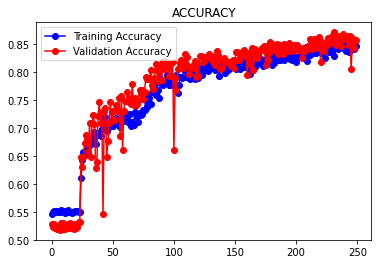

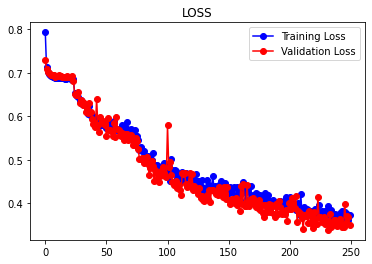

In [7]:
import matplotlib.pyplot as plt

print(history.keys())
# see how the accuracy and the loss change during training
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)


11/11 [==============================] - 6s 31ms/step - loss: 0.3728 - accuracy: 0.8512


[[157  22]
 [ 28 129]]
              precision    recall  f1-score   support

           0       0.85      0.88      0.86       179
           1       0.85      0.82      0.84       157

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336



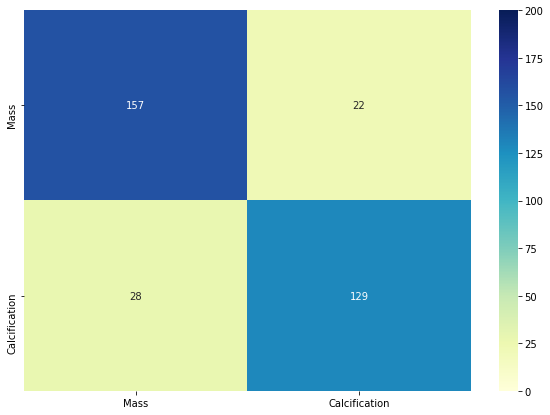

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

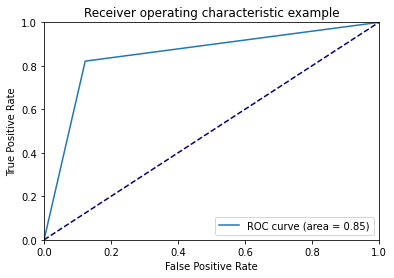

In [ ]:
fpr,tpr,th = metrics.roc_curve(test_images_labels,predictions)

roc_auc = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Experiment 2 - Exploiting Difference of Gaussians

In [ ]:
!pip install -U scikit-image

     |████████████████████████████████| 12.4MB 250kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


## Model Creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight


drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
import sys
from cv2 import cv2
from cv2 import normalize

In [ ]:
from skimage import filters
from skimage import img_as_float
from skimage.filters import difference_of_gaussians
import math

def gaussians(images):
  tmp_images = []
  for image in images:
    image = image.reshape((150,150))
    filtered_image1 = filters.difference_of_gaussians(image, math.sqrt(2), 2)
    filtered_image1 = cv2.normalize(src=filtered_image1, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image2 = filters.difference_of_gaussians(image, 2, 2*math.sqrt(2))
    filtered_image2 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image3 = filters.difference_of_gaussians(image, 2*math.sqrt(2), 4)
    filtered_image3 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image4 = filters.difference_of_gaussians(image, 4, 4*math.sqrt(2))
    filtered_image4 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image5 = filters.difference_of_gaussians(image, 4*math.sqrt(2), 8)
    filtered_image5 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image6 = filters.difference_of_gaussians(image, 8, 8*math.sqrt(2))
    filtered_image6 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image7 = filters.difference_of_gaussians(image, 8*math.sqrt(2), 16)
    filtered_image7 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    filtered_image8 = filters.difference_of_gaussians(image, 16, 16*math.sqrt(2))
    filtered_image8 = cv2.normalize(src=filtered_image2, dst=None, alpha=0, beta=65535, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    concat_image = (image, filtered_image1,filtered_image2,filtered_image3,filtered_image4,filtered_image5,filtered_image6,filtered_image7,filtered_image8)
    tmp_images.append(concat_image)
  return np.array(tmp_images)

In [ ]:
images = gaussians(images)
images.shape

In [ ]:
with open(out_path+'/miscellaneous/gaussians_images', 'wb') as file_:
        pickle.dump(images, file_)

In [8]:
with open(out_path + '/miscellaneous/gaussians_images', 'rb') as file_:
    images=pickle.load(file_)

In [ ]:
from keras.layers import Input
from keras import applications
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

def get_model():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (7, 7), activation='relu',
                          input_shape=(150, 150, 1)))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(layers.MaxPooling2D((4, 4)))
  model.add(layers.Conv2D(64, (5, 5), activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(layers.MaxPooling2D((3, 3)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(tf.keras.layers.Dropout(0.25))
  model.add(layers.GlobalAveragePooling2D())
  return model

input_shape = (150,150,1)
input1 = Input(input_shape)
input2 = Input(input_shape)
input3 = Input(input_shape)
input4 = Input(input_shape)
input5 = Input(input_shape)
input6 = Input(input_shape)
input7 = Input(input_shape)
input8 = Input(input_shape)
input9 = Input(input_shape)

arch1 = get_model()
model1 = arch1(input1)
arch2 = get_model()
model2 = arch2(input2)
arch3 = get_model()
model3 = arch3(input3)
arch4 = get_model()
model4 = arch4(input4)
arch5 = get_model()
model5 = arch5(input5)
arch6 = get_model()
model6 = arch6(input6)
arch7 = get_model()
model7 = arch7(input7)
arch8 = get_model()
model8 = arch8(input8)
arch9 = get_model()
model9 = arch9(input9)

L1_layer = Lambda(lambda tensors:K.concatenate(tensors, axis=-1))
L1_concat = L1_layer([model1, model2, model3, model4, model5, model6, model7, model8, model9])

flatten = tf.keras.layers.Flatten()(L1_concat)
dense1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer = regularizers.l1(1e-4))(flatten)
dense2 = tf.keras.layers.Dense(256,activation='relu', kernel_regularizer = regularizers.l1(1e-4))(dense1)
prediction = tf.keras.layers.Dense(1,activation='sigmoid')(dense2)
model = models.Model(inputs=[input1, input2, input3, input4, input5, input6, input7, input8, input9],outputs=prediction)

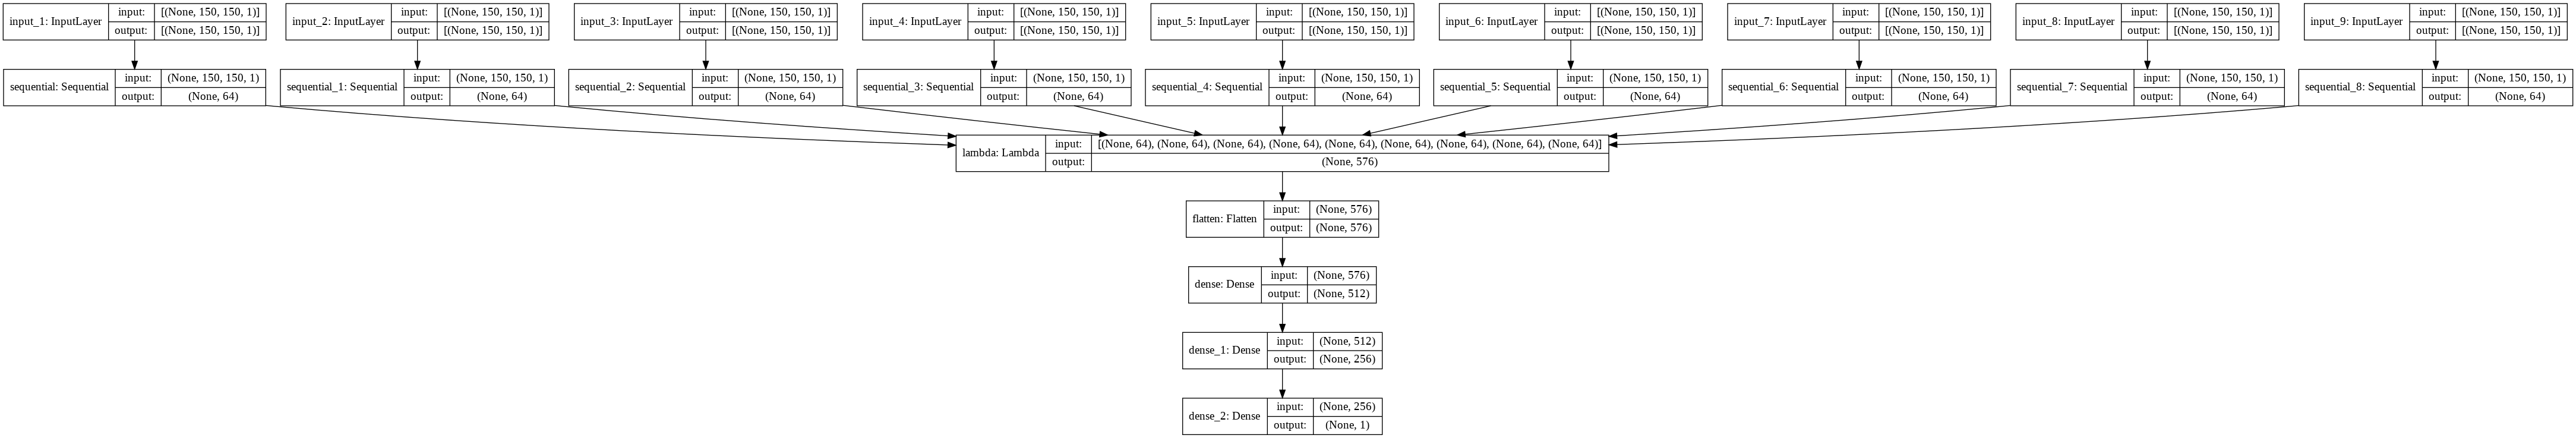

In [ ]:
tf.keras.utils.plot_model(model, to_file="img.png", show_shapes=True)

In [ ]:
from keras.utils import Sequence
class NineGenerator(Sequence):
    def __init__(self, gen1, gen2, gen3, gen4, gen5, gen6, gen7, gen8, gen9):
       self.gen1 = gen1
       self.gen2 = gen2
       self.gen3 = gen3
       self.gen4 = gen4
       self.gen5 = gen5
       self.gen6 = gen6
       self.gen7 = gen7
       self.gen8 = gen8
       self.gen9 = gen9

    def __len__(self):
       return len(self.gen1)

    def __getitem__(self, i):
       x1,y = self.gen1[i]
       x2,y2 = self.gen2[i]
       x3,y3 = self.gen3[i]
       x4,y4 = self.gen4[i]
       x5,y5 = self.gen5[i]
       x6,y6 = self.gen6[i]
       x7,y7 = self.gen7[i]
       x8,y8 = self.gen8[i]
       x9,y9 = self.gen9[i]
       return (x1,x2,x3,x4,x5,x6,x7,x8,x9), y

In [ ]:
import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from sklearn.model_selection import train_test_split
# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]
images_train, images_val, labels_train, labels_val = train_test_split(images, labels, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

tmp_train = np.split(images_train, 9, axis=1)
tmp_valid = np.split(images_val, 9, axis=1)

tmp_train[0] = tmp_train[0].reshape((2007,150,150,1))
tmp_train[1] = tmp_train[1].reshape((2007,150,150,1))
tmp_train[2] = tmp_train[2].reshape((2007,150,150,1))
tmp_train[3] = tmp_train[3].reshape((2007,150,150,1))
tmp_train[4] = tmp_train[4].reshape((2007,150,150,1))
tmp_train[5] = tmp_train[5].reshape((2007,150,150,1))
tmp_train[6] = tmp_train[6].reshape((2007,150,150,1))
tmp_train[7] = tmp_train[7].reshape((2007,150,150,1))
tmp_train[8] = tmp_train[8].reshape((2007,150,150,1))
tmp_valid[0] = tmp_valid[0].reshape((669,150,150,1))
tmp_valid[1] = tmp_valid[1].reshape((669,150,150,1))
tmp_valid[2] = tmp_valid[2].reshape((669,150,150,1))
tmp_valid[3] = tmp_valid[3].reshape((669,150,150,1))
tmp_valid[4] = tmp_valid[4].reshape((669,150,150,1))
tmp_valid[5] = tmp_valid[5].reshape((669,150,150,1))
tmp_valid[6] = tmp_valid[6].reshape((669,150,150,1))
tmp_valid[7] = tmp_valid[7].reshape((669,150,150,1))
tmp_valid[8] = tmp_valid[8].reshape((669,150,150,1))
print(labels_train.shape)

datagen = ImageDataGenerator(
    rescale=1./65535.,
    horizontal_flip=True,
    rotation_range = 40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode="nearest",
    shear_range=0.2,
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator(rescale=1./65535.)

train_generator = NineGenerator(datagen.flow(tmp_train[0],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[1],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[2],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[3],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[4],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[5],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[6],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[7],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED),
                             datagen.flow(tmp_train[8],
                               labels_train,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED))



valid_generator = NineGenerator(valid_datagen.flow(tmp_valid[0],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[1],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[2],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[3],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[4],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[5],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[6],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[7],
                               labels_val,
                               batch_size=32,
                               seed=SEED),
                             valid_datagen.flow(tmp_valid[8],
                               labels_val,
                               batch_size=32,
                               seed=SEED))


optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          epochs=500)

model.load_weights(checkpoint_filepath)

(2007,)
Epoch 1/500
63/63 [==============================] - 90s 1s/step - loss: 2.3104 - accuracy: 0.5292 - val_loss: 2.1450 - val_accuracy: 0.5531

Epoch 00001: val_loss improved from inf to 2.14497, saving model to /tmp/checkpoint
Epoch 2/500
63/63 [==============================] - 81s 1s/step - loss: 2.0939 - accuracy: 0.5609 - val_loss: 1.9442 - val_accuracy: 0.6338

Epoch 00002: val_loss improved from 2.14497 to 1.94419, saving model to /tmp/checkpoint
Epoch 3/500
63/63 [==============================] - 81s 1s/step - loss: 1.8863 - accuracy: 0.6458 - val_loss: 1.7407 - val_accuracy: 0.6771

Epoch 00003: val_loss improved from 1.94419 to 1.74072, saving model to /tmp/checkpoint
Epoch 4/500
63/63 [==============================] - 81s 1s/step - loss: 1.6971 - accuracy: 0.6633 - val_loss: 1.5901 - val_accuracy: 0.6084

Epoch 00004: val_loss improved from 1.74072 to 1.59015, saving model to /tmp/checkpoint
Epoch 5/500
63/63 [==============================] - 81s 1s/step - loss: 1.5

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/scratch_model_dog"))
with open(out_path+'/histories/scratch_model_dog_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/gaussian_model_different/assets


## Model evaluation

In [10]:
# load model and model's history
with open(out_path + '/histories/scratch_model_dog_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dog"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


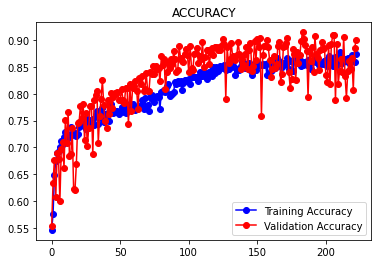

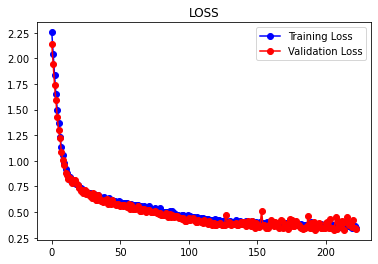

In [11]:
print(history.keys())
# see how the accuracy and the loss change during training
import matplotlib.pyplot as plt
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
test_images_tensor = gaussians(test_images_tensor)

test_images_tensor = test_images_tensor.astype('float32') / 65535

test_images_tensor = np.split(test_images_tensor, 9, axis=1)
test_images_tensor[0] = test_images_tensor[0].reshape((336,150,150,1))
test_images_tensor[1] = test_images_tensor[1].reshape((336,150,150,1))
test_images_tensor[2] = test_images_tensor[2].reshape((336,150,150,1))
test_images_tensor[3] = test_images_tensor[3].reshape((336,150,150,1))
test_images_tensor[4] = test_images_tensor[4].reshape((336,150,150,1))
test_images_tensor[5] = test_images_tensor[5].reshape((336,150,150,1))
test_images_tensor[6] = test_images_tensor[6].reshape((336,150,150,1))
test_images_tensor[7] = test_images_tensor[7].reshape((336,150,150,1))
test_images_tensor[8] = test_images_tensor[8].reshape((336,150,150,1))

test_loss, test_acc = model.evaluate((test_images_tensor[0], test_images_tensor[1], test_images_tensor[2], test_images_tensor[3], test_images_tensor[4], test_images_tensor[5], test_images_tensor[6], test_images_tensor[7], test_images_tensor[8]),test_images_labels)

11/11 [==============================] - 7s 45ms/step - loss: 0.3882 - accuracy: 0.8542


[[152  27]
 [ 22 135]]
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       179
           1       0.83      0.86      0.85       157

    accuracy                           0.85       336
   macro avg       0.85      0.85      0.85       336
weighted avg       0.85      0.85      0.85       336



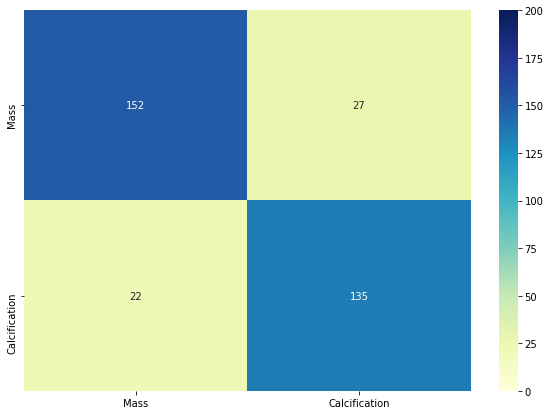

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

predictions = (model.predict((test_images_tensor[0], test_images_tensor[1], test_images_tensor[2], test_images_tensor[3], test_images_tensor[4], test_images_tensor[5], test_images_tensor[6], test_images_tensor[7], test_images_tensor[8])) > 0.5).astype("int32")
np.save(os.path.join(out_path,"gaussian_predictions"), predictions)

print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

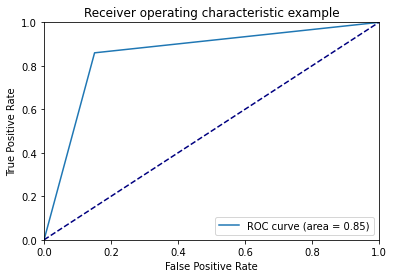

In [ ]:
fpr,tpr,th = metrics.roc_curve(test_images_labels,predictions)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)

roc_auc = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Experiment 3 - DCCNN v1

## Model Creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
import random
from sklearn.utils import class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from keras.layers import Input
from keras import Model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

def inception_module_6a(layer_in, depth=224):
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv5 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv4)
  conv6 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv7 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv3, conv6, conv7], axis=-1)
  return layer_out

def inception_module_7a(layer_in, depth=224):
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  conv5 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv6 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  conv7 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv6)
  conv8 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv7)
  conv9 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv8)
  pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv10 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv4, conv9, conv10], axis=-1)
  return layer_out

def inception_module_6b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def inception_module_7b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def getDCNN(input):
  layer1 = layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(input)
  layer3 = layers.Conv2D(32,(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer1)
  layer4 = layers.Conv2D(64,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer3)
  layer5 = layers.MaxPooling2D((2,2), padding="same")(layer4)
  layer6 = layers.Conv2D(80,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer5)
  layer7 = layers.Conv2D(192,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer6)#concatenate after
  layer8 = layers.MaxPooling2D((2,2))(layer7)
  layer9 = inception_module_6a(layer8,depth=56)
  layer10 = inception_module_6a(layer9,depth=56)#concatenate after
  layer11 = inception_module_6b(layer10,depth1=144,depth2=144)
  layer12 = inception_module_7a(layer11,depth=128)
  layer13 = inception_module_7a(layer12,depth=128)# concatenate after
  layer14 = inception_module_7b(layer13,depth1=192,depth2=192)
  layer15 = layers.AveragePooling2D((8,8))(layer14)
  
  layer7_1 = layers.AveragePooling2D((72,72))(layer7)
  layer10_1 = layers.AveragePooling2D((36,36))(layer10)
  layer13_1 = layers.AveragePooling2D((17,17))(layer13)

  layer_out = concatenate([layer7_1, layer10_1, layer13_1,layer15], axis=-1)
  return layer_out

def getModel():
  input = Input(shape=(150, 150, 1))
  dcnn1 = getDCNN(input)
  dcnn2 = getDCNN(input)
  concatenation = concatenate([dcnn1, dcnn2], axis=-1)
  flattener = layers.Flatten()(concatenation)
  dense1 = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(flattener)
  dense2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense1)
  dense3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense2)
  output_layer = layers.Dense(1, activation='sigmoid')(dense3)
  model = Model(inputs=input, outputs=output_layer)
  model.summary()
  return model

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
#MODEL 
model = getModel()
images = images.reshape((2676, 150, 150, 1))

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    rescale=1./65535.,
    validation_split=0.2 ,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator(rescale=1./65535.,
                                   validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               shuffle=True,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)



STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(
          train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d_752 (Conv2D)             (None, 148, 148, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_799 (Conv2D)             (None, 148, 148, 32) 320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_753 (Conv2D)             (None, 147, 147, 32) 4128        conv2d_752[0][0]                 
____________________________________________________________________________________________

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/scratch_model_dccnn_v1"))
with open(out_path+'/histories/scratch_model_dccnn_v1_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/scratch_model_4_rot/assets


## Model evaluation

In [13]:
# load model and model's history
with open(out_path + '/histories/scratch_model_dccnn_v1_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dccnn_v1"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


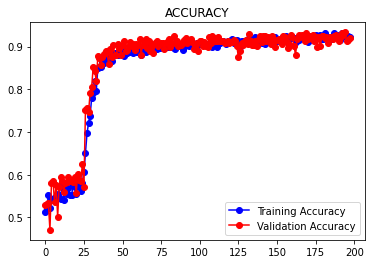

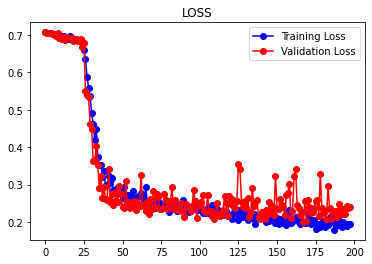

In [14]:
print(history.keys())
# see how the accuracy and the loss change during training
import matplotlib.pyplot as plt
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)


11/11 [==============================] - 2s 99ms/step - loss: 0.3119 - accuracy: 0.8869


[[164  15]
 [ 23 134]]
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       179
           1       0.90      0.85      0.88       157

    accuracy                           0.89       336
   macro avg       0.89      0.88      0.89       336
weighted avg       0.89      0.89      0.89       336



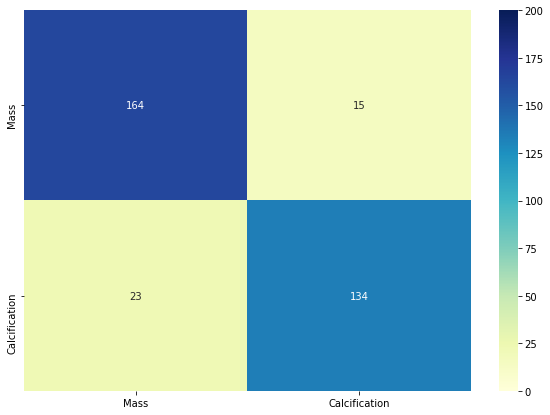

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

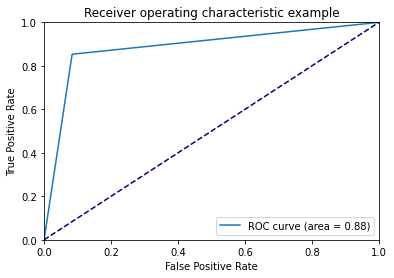

In [ ]:
fpr,tpr,th = metrics.roc_curve(test_images_labels,predictions)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)

roc_auc = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Experiment 3 - DCCNN v2

## Model Creation

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import pickle
import random
from sklearn.utils import class_weight

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
from tensorflow.keras import models
from google.colab import drive
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
out_path = '/content/drive/MyDrive/Barsellotti_Paolini'

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
def load_training():
  images = np.load(os.path.join(out_path,'train_tensor.npy'))
  labels = np.load(os.path.join(out_path,'train_labels.npy'))
  return images,labels

In [ ]:
def change_label(labels):
  new_labels = list()
  
  for label in labels:
    if label==1 or label==2:#mass
      new_labels.append(0)
    if label==3 or label==4:#calcification
      new_labels.append(1)
  return np.array(new_labels)


images, labels= load_training()
# extract odd elements and change their labels
labels = change_label(labels[1::2])
images = images[1::2]

In [ ]:
# reproducible results
SEED = 12345
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
from keras.layers import Input
from keras import Model
from keras.layers.merge import concatenate
from keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras import layers

from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten

def inception_module_6a(layer_in, depth=224):
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv5 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv4)
  conv6 = Conv2D(depth, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv7 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv3, conv6, conv7], axis=-1)
  return layer_out

def inception_module_7a(layer_in, depth=224):
  conv1 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  conv5 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv6 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv5)
  conv7 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv6)
  conv8 = Conv2D(depth, (3,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv7)
  conv9 = Conv2D(depth, (1,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv8)
  pool = layers.AveragePooling2D((3,3), strides=(1,1), padding='same')(layer_in)
  conv10 = Conv2D(depth, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(pool)
  layer_out = concatenate([conv1, conv4, conv9, conv10], axis=-1)
  return layer_out

def inception_module_6b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2,2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def inception_module_7b(layer_in, depth1,depth2):
  conv1 = Conv2D(depth1, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv2 = Conv2D(depth2, (1,1), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer_in)
  conv3 = Conv2D(depth2, (3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv2)
  conv4 = Conv2D(depth2, (3,3), strides=(2, 2), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(conv3)
  pool = MaxPooling2D((3,3), strides=(2,2))(layer_in)
  layer_out = concatenate([conv1, conv4, pool], axis=-1)
  return layer_out

def getDCNN(input):
  layer1 = layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(input)
  layer2 = layers.MaxPooling2D((2,2))(layer1)
  layer3 = layers.Conv2D(32,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer2)
  layer4 = layers.Conv2D(64,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer3)
  layer5 = layers.MaxPooling2D((2,2), padding="same")(layer4)
  layer6 = layers.Conv2D(80,(1,1), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer5)
  layer7 = layers.Conv2D(192,(3,3), activation='relu', kernel_regularizer=regularizers.l2(1e-6))(layer6)#concatenate after
  layer8 = layers.MaxPooling2D((2,2))(layer7)
  layer9 = inception_module_6a(layer8,depth=56)
  layer10 = inception_module_6a(layer9,depth=56)#concatenate after
  layer11 = inception_module_6b(layer10,depth1=144,depth2=144)
  layer12 = inception_module_7a(layer11,depth=128)
  layer13 = inception_module_7a(layer12,depth=128)# concatenate after
  layer14 = inception_module_7b(layer13,depth1=192,depth2=192)
  layer15 = layers.GlobalAveragePooling2D()(layer14)

  layer7_1 = layers.GlobalAveragePooling2D()(layer7)
  layer10_1 = layers.GlobalAveragePooling2D()(layer10)
  layer13_1 = layers.GlobalAveragePooling2D()(layer13)

  layer_out = concatenate([layer7_1, layer10_1, layer13_1,layer15], axis=-1)
  return layer_out

def getModel():
  input = Input(shape=(150, 150, 1))
  dcnn1 = getDCNN(input)
  dcnn2 = getDCNN(input)
  concatenation = concatenate([dcnn1, dcnn2], axis=-1)
  flattener = layers.Flatten()(concatenation)
  dense1 = layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(flattener)
  dense2 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense1)
  dense3 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-6))(dense2)
  output_layer = layers.Dense(1, activation='sigmoid')(dense3)
  model = Model(inputs=input, outputs=output_layer)
  model.summary()
  return model

In [ ]:
from skimage import data, img_as_float
from skimage import exposure
from skimage import data, img_as_float
from skimage import exposure
import random
from tensorflow.image import rot90

def preprocess(img):
  return rot90(img, k=random.randint(1,4))

In [ ]:
#MODEL 
model = getModel()
images = images.reshape((2676, 150, 150, 1))

# create a random permutation of images/labels
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
labels = labels[randomize]

datagen = ImageDataGenerator(
    rescale=1./65535.,
    validation_split=0.2 ,
    horizontal_flip=True,
    vertical_flip = True,
    rotation_range = 10,
    zoom_range=[0.7,1.3],
    preprocessing_function = preprocess
    )

valid_datagen = ImageDataGenerator(rescale=1./65535.,
                                   validation_split=0.2)


train_generator = datagen.flow(images,
                               labels,
                               batch_size=32,
                               shuffle=True,
                               seed=SEED,
                               subset="training")

valid_generator = valid_datagen.flow(images,
                               labels,
                               shuffle=True,
                               batch_size=32,
                               subset="validation",
                               seed=SEED)



STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size


# class weighting
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(labels),
                                                 labels)
class_weight_dict = dict(enumerate(class_weights))


optimizer = tf.keras.optimizers.Adam(1e-4)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

checkpoint_filepath = '/tmp/checkpoint'

checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', 
                              verbose=1, save_best_only=True, mode='min',save_weights_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

history = model.fit(
          train_generator,
          validation_data=valid_generator,
          callbacks=[es,checkpoint],
          steps_per_epoch=STEP_SIZE_TRAIN,
          validation_steps=STEP_SIZE_VALID,
          class_weight = class_weight_dict,
          epochs=250)

model.load_weights(checkpoint_filepath)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 148, 148, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 148, 148, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 74, 74, 32)   0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# save model and model history
model.save(os.path.join(out_path,"models/scratch_model_dccnn_v2"))
with open(out_path+'/histories/scratch_model_dccnn_v2_history', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ProgettoMIRCV/scratch_model_4_rot/assets


## Model evaluation

In [15]:
# load model and model's history
with open(out_path + '/histories/scratch_model_dccnn_v2_history', 'rb') as file:
    history=pickle.load(file)

model = tf.keras.models.load_model(os.path.join(out_path, "models/scratch_model_dccnn_v2"))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


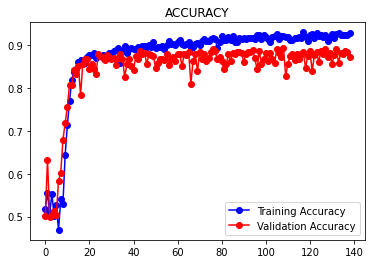

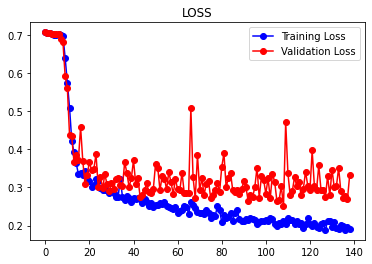

In [16]:
print(history.keys())
# see how the accuracy and the loss change during training
import matplotlib.pyplot as plt
plt.title('ACCURACY')
plt.plot(history['accuracy'],'bo-',label = 'Training Accuracy')
plt.plot(history['val_accuracy'],'ro-',label = 'Validation Accuracy')
plt.legend()
plt.show()
plt.title('LOSS')
plt.plot(history['loss'],'bo-',label = 'Training Loss')
plt.plot(history['val_loss'],'ro-',label = 'Validation Loss')
plt.legend()
plt.show()

In [ ]:
# Test set 

test_images_tensor = np.load(out_path + '/public_test_tensor.npy')
test_images_labels = np.load(out_path + '/public_test_labels.npy')
test_images_tensor = test_images_tensor[1::2]
test_images_labels = test_images_labels[1::2]
test_images_labels = change_label(test_images_labels)
test_images_tensor = test_images_tensor.reshape((336, 150, 150, 1))


test_images_tensor = test_images_tensor.astype('float32') / 65535


test_loss, test_acc = model.evaluate(test_images_tensor,test_images_labels)


11/11 [==============================] - 2s 40ms/step - loss: 0.2832 - accuracy: 0.8720


[[167  12]
 [ 31 126]]
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       179
           1       0.91      0.80      0.85       157

    accuracy                           0.87       336
   macro avg       0.88      0.87      0.87       336
weighted avg       0.88      0.87      0.87       336



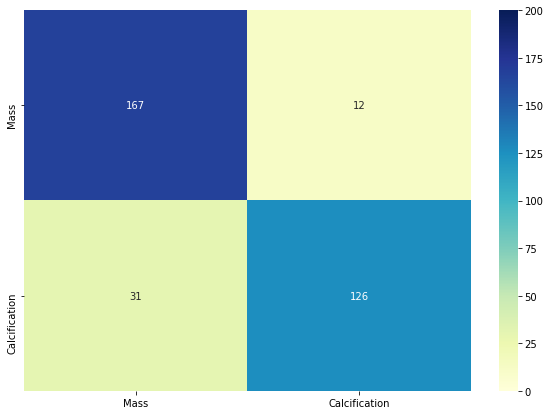

In [ ]:
# confusion matrix
from sklearn import metrics
import seaborn as sn
import pandas as pd
predictions = (model.predict(test_images_tensor) > 0.5).astype("int32")


print(metrics.confusion_matrix(test_images_labels, predictions))
array = metrics.confusion_matrix(test_images_labels, predictions)
df_cm = pd.DataFrame(array, index = ["Mass", "Calcification"],
                  columns = ["Mass", "Calcification"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, vmin=0, vmax=200, annot=True, fmt="d", cmap="YlGnBu")
print(metrics.classification_report(test_images_labels,predictions))

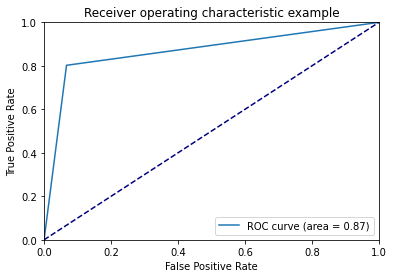

In [ ]:
fpr,tpr,th = metrics.roc_curve(test_images_labels,predictions)
# Sensitivty = TPR(True Positive Rate)= Recall = TP/(TP+FN)
# (1 - Specificity) = FPR(False Positive Rate)= FP/(TN+FP)

roc_auc = metrics.roc_auc_score(test_images_labels,predictions)

from matplotlib import pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()